### **0. Import Statements**

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, auc
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import NearestNeighbors
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

from tqdm import tqdm
import json
import csv
import os
import pandas as pd
import numpy as np
import joblib
import time
import ast

import seaborn as sns
import matplotlib.pyplot as plt

### **1. Load the Processed Data**

In [3]:
# Processed JSON file path
final_joke_dataset = r'..\..\data\processed\output_final_joke_dataset_expanded.json'

# Load data in chunks to prevent memory overload, added this to stop my computer from crashing :) 
chunk_size = 5000 
df_chunks = []

with tqdm(total=84824, desc="Loading JSON data") as pbar:
    for chunk in pd.read_json(final_joke_dataset, lines=True, chunksize=chunk_size):
        df_chunks.append(chunk)
        pbar.update(len(chunk))

# Concatenate the chunks into a single DataFrame
df = pd.concat(df_chunks, ignore_index=True)

print(df.head())

Loading JSON data: 100%|█████████▉| 84818/84824 [01:24<00:00, 998.93it/s] 


       category  embedding_0  embedding_1  embedding_2  embedding_3  \
0  Relationship    -0.022256    -0.013339     0.014236     0.033212   
1    Dark Humor     0.057544     0.026880     0.004598     0.029653   
2        Animal     0.045314    -0.033507     0.007574     0.043311   
3   Work/Office     0.018394     0.045588     0.005402     0.047803   
4    Dark Humor     0.013119     0.043620     0.017635     0.065683   

   embedding_4  embedding_5  embedding_6  embedding_7  embedding_8  ...  \
0    -0.066916    -0.034981    -0.016336     0.014150    -0.038887  ...   
1     0.000250    -0.021385     0.005029     0.006007    -0.039089  ...   
2    -0.028089    -0.024836    -0.004601    -0.029620    -0.042251  ...   
3     0.006830    -0.003354    -0.029003    -0.013168     0.008596  ...   
4    -0.056505    -0.037057     0.032601     0.001201     0.072673  ...   

   embedding_1526  embedding_1527  embedding_1528  embedding_1529  \
0       -0.037339        0.013376       -0.012848    

### Exploratory Data Analysis (EDA)


In [4]:
# Display summary statistics for numerical columns
print("\nSummary Statistics:")
print(df.describe())


Summary Statistics:
        embedding_0   embedding_1   embedding_2   embedding_3   embedding_4  \
count  84818.000000  84818.000000  84818.000000  84818.000000  84818.000000   
mean       0.006485      0.005761     -0.011550      0.019375     -0.016889   
std        0.026576      0.027903      0.029341      0.026542      0.028586   
min       -0.115910     -0.115522     -0.117002     -0.081943     -0.129535   
25%       -0.011430     -0.013178     -0.031822      0.001380     -0.036680   
50%        0.006098      0.005895     -0.012248      0.019532     -0.017199   
75%        0.024296      0.024611      0.007890      0.037508      0.002403   
max        0.116995      0.115668      0.129793      0.122343      0.105479   

        embedding_5   embedding_6   embedding_7   embedding_8   embedding_9  \
count  84818.000000  84818.000000  84818.000000  84818.000000  84818.000000   
mean      -0.021158      0.004069      0.008157     -0.011936     -0.013225   
std        0.025222      0.027

In [7]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
category          0
embedding_0       0
embedding_1       0
embedding_2       0
embedding_3       0
                 ..
embedding_1531    0
embedding_1532    0
embedding_1533    0
embedding_1534    0
embedding_1535    0
Length: 1537, dtype: int64


In [8]:
df['category'].value_counts()

category
Puns                        16390
Dark Humor                  15802
Relationship                11998
Ethnic                       5674
One-Liners                   4416
Animal                       3439
Political                    3335
Religious                    2841
Work/Office                  2798
Doctor/Health                2562
Tech                         2045
Marriage                     1943
Dad                          1932
Blonde                       1543
Science                      1268
Celebrity                    1239
Kids                         1216
School                        957
Food                          813
Lawyer                        564
Punishments/Consequences      562
Insult                        474
Sports                        407
Yo Mama                       284
In-Law                        165
Knock-Knock                   151
Name: count, dtype: int64

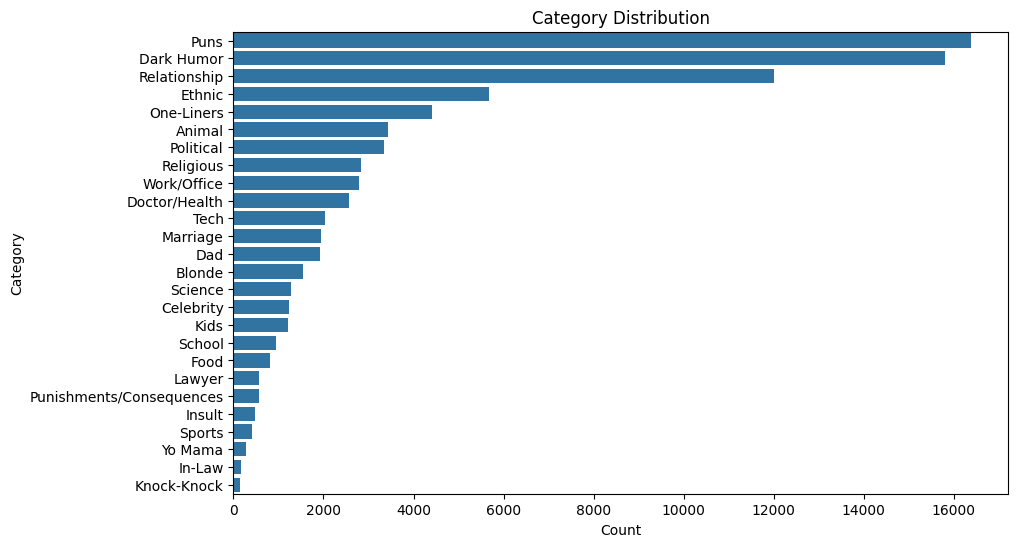

In [7]:
# Plot distribution of the 'category' column
plt.figure(figsize=(10, 6))
sns.countplot(y='category', data=df, order=df['category'].value_counts().index)
plt.title('Category Distribution')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()


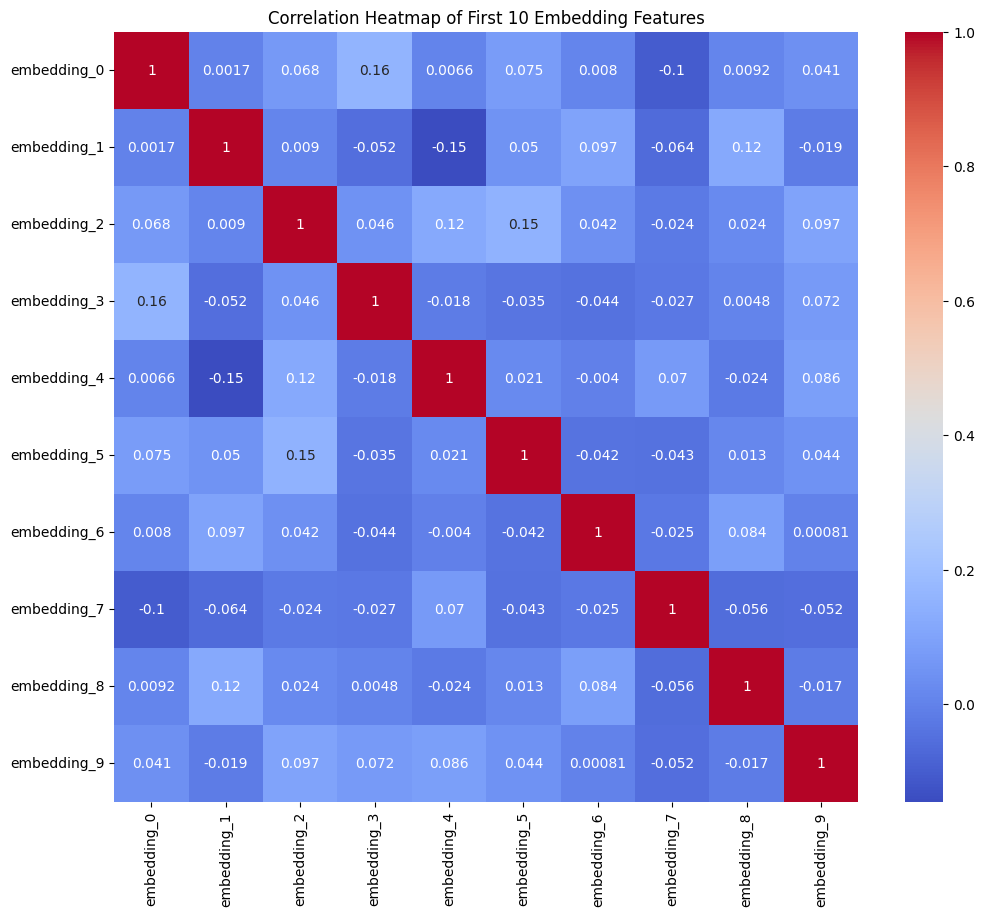

In [9]:
# Correlation heatmap for the first few embedding features
plt.figure(figsize=(12, 10))
sns.heatmap(df.iloc[:, 1:11].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of First 10 Embedding Features')
plt.show()


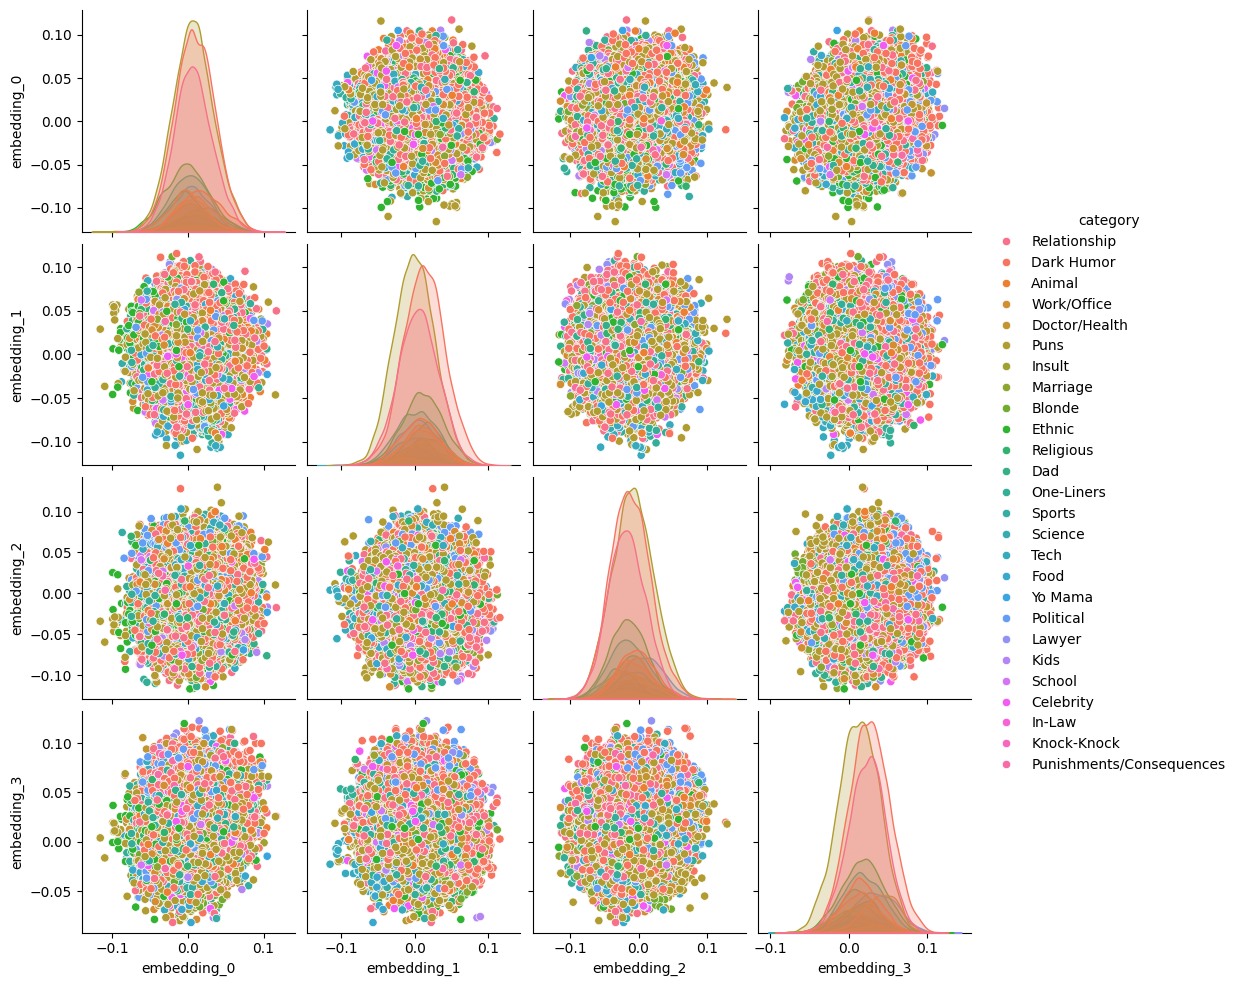

In [9]:
# Pairplot for selected embedding features and category
selected_features = ['embedding_0', 'embedding_1', 'embedding_2', 'embedding_3']
sns.pairplot(df[selected_features + ['category']], hue='category', palette='husl')
plt.show()

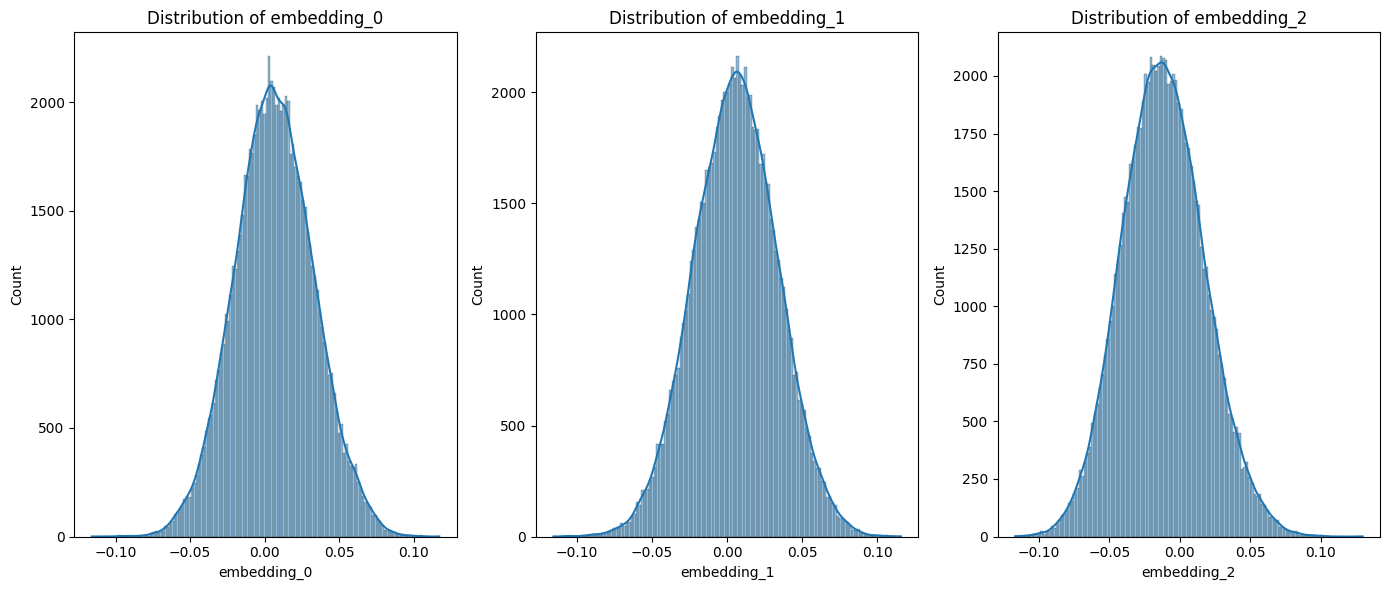

In [10]:
# Distribution of the embedding features
plt.figure(figsize=(14, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    sns.histplot(df[f'embedding_{i}'], kde=True)
    plt.title(f'Distribution of embedding_{i}')
plt.tight_layout()
plt.show()

### **2. Prepare the Data for Modeling**

first we start by doing a basic randomforest model with no finetuning

In [11]:
# Encode the categories to numerical labels
label_encoder = LabelEncoder()
df['category_encoded'] = label_encoder.fit_transform(df['category'])

# Features (X) are the embeddings
X = df.drop(columns=['category', 'category_encoded'])

# Labels (y) are the encoded category
y = df['category_encoded']

# Combine X and y to drop rows with any missing values
data = pd.concat([X, y.reset_index(drop=True)], axis=1)

# Drop rows with missing values
data = data.dropna()

# Separate X and y again
X = data.drop(columns=['category_encoded'])
y = data['category_encoded']

# Perform train-test split with stratification
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)


### **Note on Feature Selection and Sampling Strategies**

We attempted feature selection by reducing the dimensions of the embeddings, but this did not improve model performance.
Additionally, we tried SMOTE and other sampling strategies to address class imbalance, but these methods did not yield better results.
Therefore, we proceed without feature selection or sampling adjustments.

### **3. Set Up the Base Model**

In [12]:
# Initialize the Random Forest classifier with default parameters
base_rf_classifier = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'  # Handle class imbalance
    verbose1
)

# Perform k-fold cross-validation
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

print("Training the base model with cross-validation...")

cv_scores = cross_val_score(base_rf_classifier, X_train, y_train, cv=skf, scoring='f1_macro', n_jobs=-1)

print(f"Cross-validation scores (F1 Macro): {cv_scores}")
print(f"Mean CV F1 Macro Score: {np.mean(cv_scores):.4f}")

# Train the base model on the entire training data
print("Fitting the base model on the entire training data...")
base_rf_classifier.fit(X_train, y_train)

# Save the base model
model_dir = 'models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

base_model_path = os.path.join(model_dir, 'base_rf_classifier.joblib')
joblib.dump(base_rf_classifier, base_model_path)
print(f"Base model saved to {base_model_path}")


Training the base model with cross-validation...
Cross-validation scores (F1 Macro): [0.51442096 0.51062784 0.52561117 0.51749834 0.51574022]
Mean CV F1 Macro Score: 0.5168
Fitting the base model on the entire training data...
Base model saved to models\base_rf_classifier.joblib


### **4. Set Up the Hypertuned Model**

In [17]:
# Use a smaller subset of the data for hyperparameter tuning to speed up computation
# Let's take a 20% sample of the training data
X_train_sample, _, y_train_sample, _ = train_test_split(
    X_train, y_train, test_size=0.8, random_state=42, stratify=y_train
)

print(f"Using a sample of {X_train_sample.shape[0]} instances for hyperparameter tuning.")

# Define the parameter distributions for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 150],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

rf_classifier = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced', verbose=1)

random_search = RandomizedSearchCV(
    estimator=rf_classifier,
    param_distributions=param_dist,
    n_iter=10,  # Reduced number of iterations
    cv=3,       # Reduced number of folds
    scoring='f1_macro',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

print("Performing hyperparameter tuning with RandomizedSearchCV...")
# Perform RandomizedSearchCV
random_search.fit(X_train_sample, y_train_sample)

print("Best parameters found: ", random_search.best_params_)
print(f"Best cross-validation F1 Macro Score: {random_search.best_score_:.4f}")

# Get the best model
hypertuned_rf_classifier = random_search.best_estimator_

# Train the hypertuned model on the full training data
print("Fitting the hypertuned model on the entire training data...")
hypertuned_rf_classifier.fit(X_train, y_train)

# Save the hypertuned model
hypertuned_model_path = os.path.join(model_dir, 'hypertuned_rf_classifier.joblib')
joblib.dump(hypertuned_rf_classifier, hypertuned_model_path)
print(f"Hypertuned model saved to {hypertuned_model_path}")

Using a sample of 15267 instances for hyperparameter tuning.
Performing hyperparameter tuning with RandomizedSearchCV...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.3min finished


Best parameters found:  {'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 20, 'bootstrap': False}
Best cross-validation F1 Macro Score: 0.4757
Fitting the hypertuned model on the entire training data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  9.6min finished


Hypertuned model saved to models\hypertuned_rf_classifier.joblib


### **5. Test and Compare the Models**

In [42]:
# Classification reports

# Predict on the validation set using base model
y_pred_base = base_rf_classifier.predict(X_val)

print("\nBase Model Classification Report:")
print(classification_report(y_val, y_pred_base, target_names=label_encoder.classes_))


Base Model Classification Report:
                          precision    recall  f1-score   support

                  Animal       0.84      0.47      0.60       344
                  Blonde       0.93      0.72      0.81       154
               Celebrity       0.91      0.25      0.39       124
                     Dad       0.74      0.39      0.51       193
              Dark Humor       0.53      0.77      0.63      1580
           Doctor/Health       0.90      0.58      0.71       256
                  Ethnic       0.90      0.52      0.66       567
                    Food       0.96      0.30      0.45        81
                  In-Law       1.00      0.18      0.30        17
                  Insult       0.83      0.21      0.34        47
                    Kids       0.61      0.25      0.35       122
             Knock-Knock       1.00      0.40      0.57        15
                  Lawyer       0.80      0.50      0.62        56
                Marriage       0.61     

In [43]:
# Predict on the validation set using hypertuned model
y_pred_hypertuned = hypertuned_rf_classifier.predict(X_val)

print("\nHypertuned Model Classification Report:")
print(classification_report(y_val, y_pred_hypertuned, target_names=label_encoder.classes_))

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s



Hypertuned Model Classification Report:
                          precision    recall  f1-score   support

                  Animal       0.65      0.73      0.69       344
                  Blonde       0.89      0.81      0.85       154
               Celebrity       0.82      0.45      0.58       124
                     Dad       0.62      0.59      0.60       193
              Dark Humor       0.68      0.65      0.67      1580
           Doctor/Health       0.78      0.83      0.81       256
                  Ethnic       0.81      0.68      0.74       567
                    Food       0.72      0.57      0.63        81
                  In-Law       1.00      0.29      0.45        17
                  Insult       0.70      0.34      0.46        47
                    Kids       0.54      0.49      0.52       122
             Knock-Knock       0.77      0.67      0.71        15
                  Lawyer       0.80      0.79      0.79        56
                Marriage       0.4

[Parallel(n_jobs=12)]: Done 150 out of 150 | elapsed:    0.1s finished


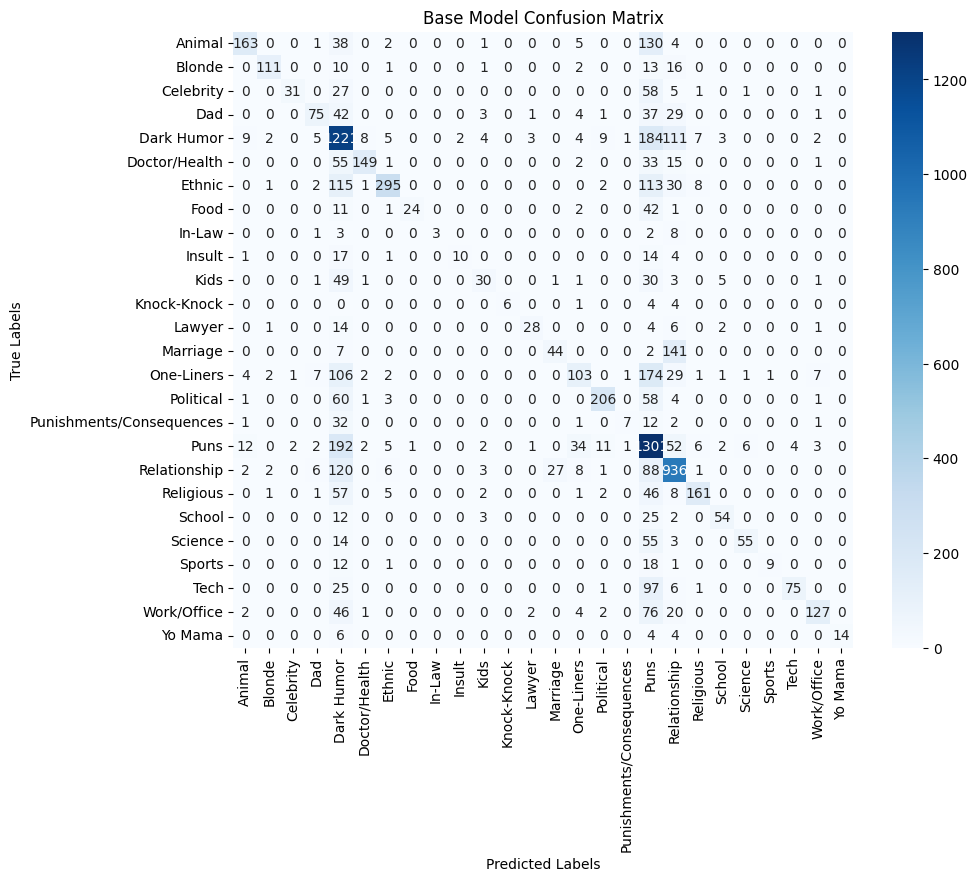

In [37]:
# Compute and plot the confusion matries individually 
cm_base = confusion_matrix(y_val, y_pred_base)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_base, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Base Model Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

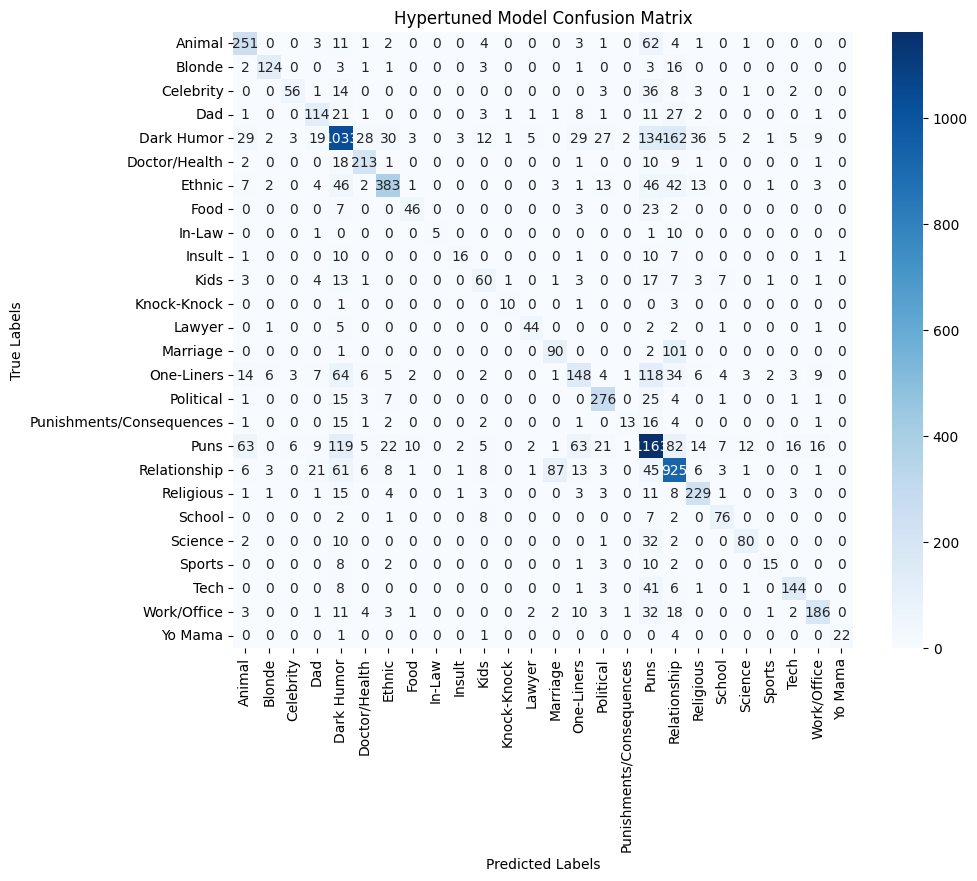

<Figure size 640x480 with 0 Axes>

In [32]:
# Compute and plot the confusion matries individually 
cm_hypertuned = confusion_matrix(y_val, y_pred_hypertuned)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_hypertuned, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Hypertuned Model Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


plt.tight_layout()

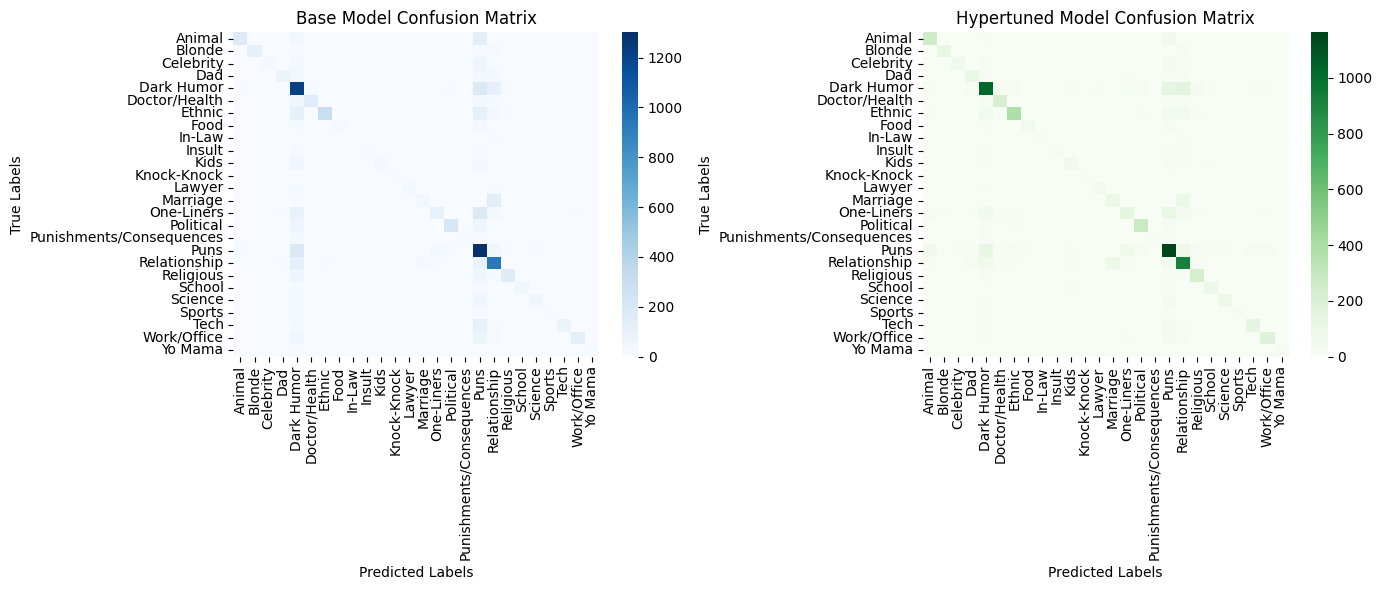

In [35]:
# Compute and plot the confusion matrixs together 
cm_base = confusion_matrix(y_val, y_pred_base)
cm_hypertuned = confusion_matrix(y_val, y_pred_hypertuned)

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(cm_base, ax=axes[0], annot=False, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
axes[0].set_title('Base Model Confusion Matrix')
axes[0].set_xlabel('Predicted Labels')
axes[0].set_ylabel('True Labels')

sns.heatmap(cm_hypertuned, ax=axes[1], annot=False, fmt='d', cmap='Greens',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
axes[1].set_title('Hypertuned Model Confusion Matrix')
axes[1].set_xlabel('Predicted Labels')
axes[1].set_ylabel('True Labels')

plt.tight_layout()
plt.show()
